[*********************100%***********************]  1 of 1 completed
                    Count_Open  Count_High  Count_Low  Count_Close  Count_Sum
Count of OHLC Hits                                                           
20.0                     121.0       112.0      133.0        124.0      490.0
21.0                     124.0       133.0      108.0        123.0      488.0
18.0                      68.0        50.0       83.0         68.0      269.0
19.0                      63.0        77.0       54.0         65.0      259.0
84.0                      63.0        56.0       47.0         70.0      236.0
...                        ...         ...        ...          ...        ...
169.0                      1.0         0.0        0.0          0.0        1.0
171.0                      0.0         0.0        1.0          0.0        1.0
172.0                      0.0         0.0        0.0          1.0        1.0
173.0                      1.0         0.0        0.0          0.0       

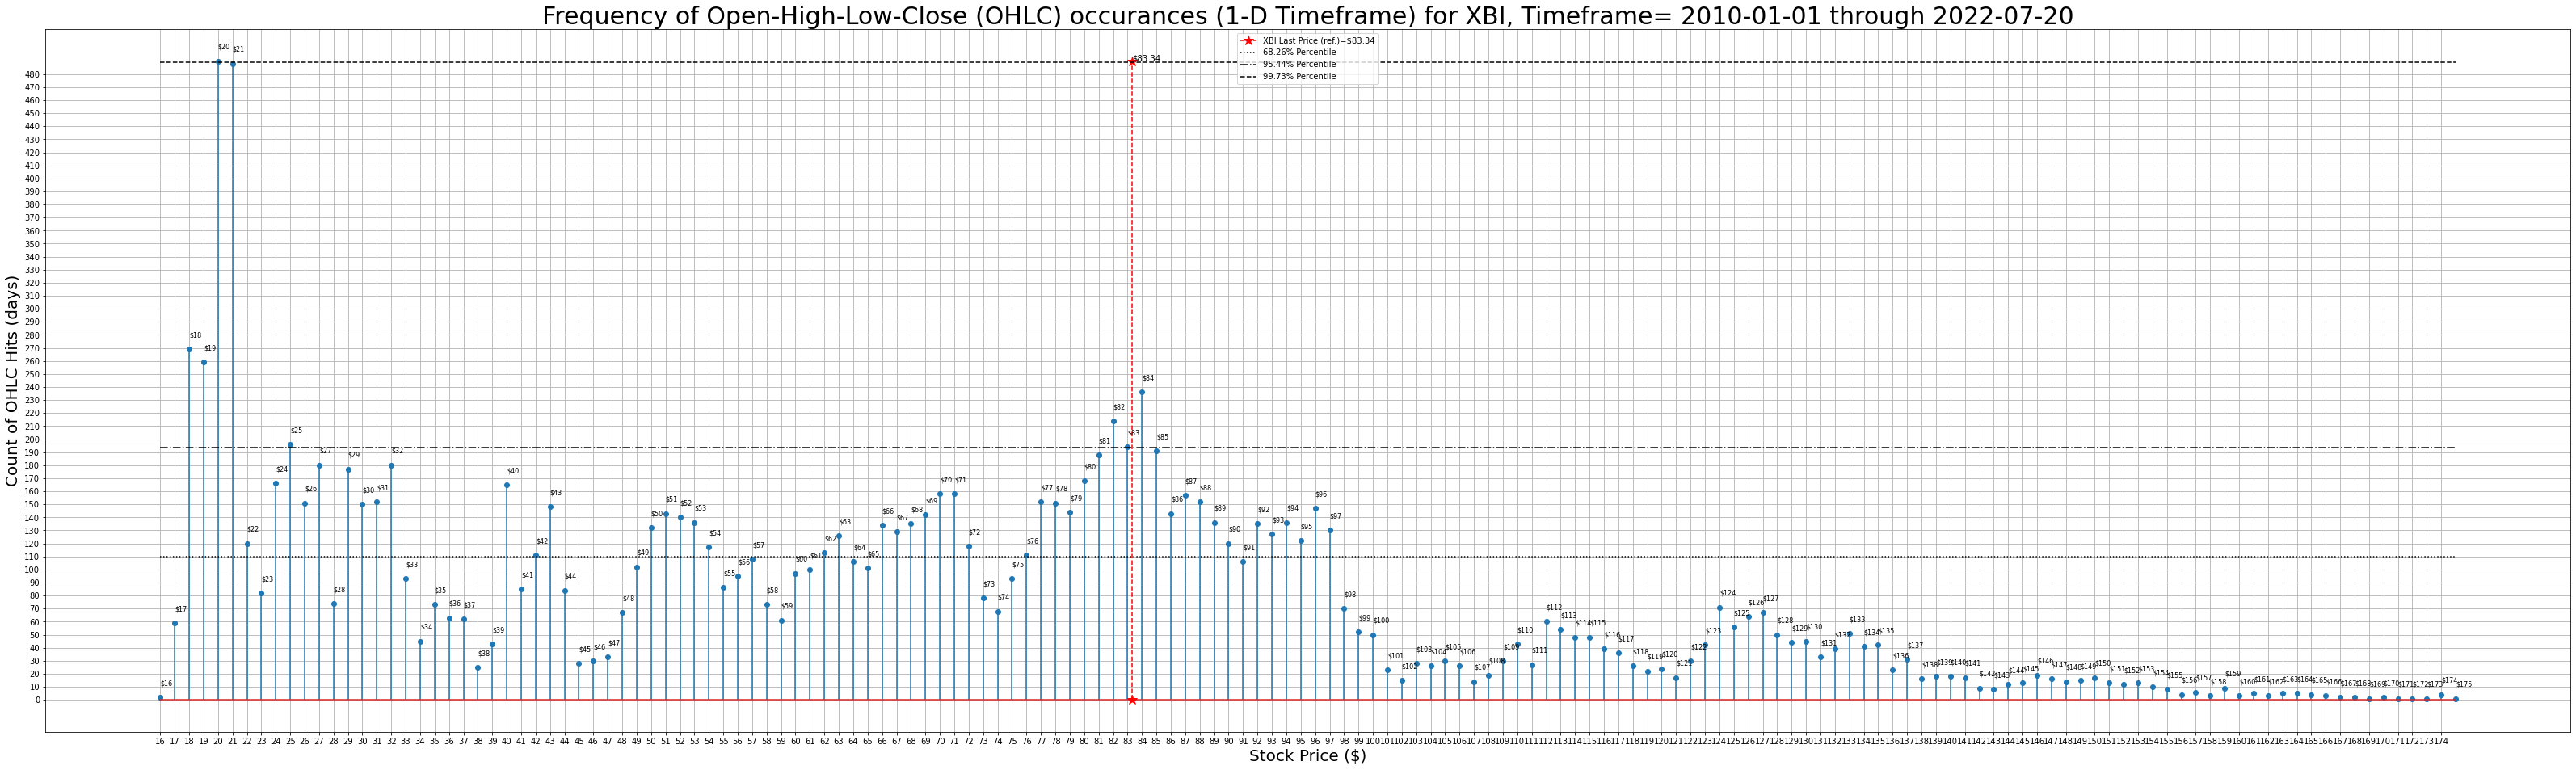

In [74]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date


def GetStockData(ticker,start_date,end_date,interval):
    df = yf.download(ticker, start_date, end_date,interval=interval).dropna()
    return(df)

def Round(df,base):
    df = base*round(df/base)
    return(df)

def GroupOHLC(df):
    df['Date']=df.index
    
    #Group by individual OHLC columns
    dfo=pd.DataFrame(df.groupby('Open').count().sort_values(by='Date',ascending=False).Date)
    dfh=pd.DataFrame(df.groupby('High').count().sort_values(by='Date',ascending=False).Date)
    dfl=pd.DataFrame(df.groupby('Low').count().sort_values(by='Date',ascending=False).Date)
    dfc=pd.DataFrame(df.groupby('Close').count().sort_values(by='Date',ascending=False).Date)
    
    #Join OHLC columns
    df=dfo.join(dfh,how='outer',rsuffix='o',sort=True)
    df=df.join(dfl,how='outer',rsuffix='h',sort=True)
    df=df.join(dfc,how='outer',rsuffix='l',sort=True).fillna(0)
    
    #Sum and name OHLC columns
    df['total']=df.sum(axis=1)
    df.columns=['Count_Open','Count_High','Count_Low','Count_Close','Count_Sum']
    df=df.sort_values(by='Count_Sum',ascending=False)
    df.index.name='Count of OHLC Hits'
    return(df)

def PlotData(df,Last_Price,ticker,start_date,end_date):
    #Plot Stem-plot
    fig, ax = plt.subplots()
    plt.stem(df.index,df.Count_Sum)
    #Add Grid
    ax.grid()
    #Resize
    fig.set_size_inches(56, 16)
    #Add X-ticks
    ax.xaxis.set_ticks(np.arange(np.min(df.index),np.max(df.index),1))
    #Add Y-ticks
    ax.yaxis.set_ticks(np.arange(0,np.max(df.Count_Sum),10))
    #Set X-label
    ax.set_xlabel('Stock Price ($)',size=20)
    #Set Y-label
    ax.set_ylabel('Count of OHLC Hits (days)',size=20)
    #Set Title
    ax.set_title('Frequency of Open-High-Low-Close (OHLC) occurances (1-D Timeframe) for '+ticker+', Timeframe= '+str(start_date)+' through '+str(end_date),size=30)
    
    
    #Add data labels
    for x,y in zip(df.index,df.Count_Sum):

        label = "${:.0f}".format(x)

        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,15), # distance from text to points (x,y)
                     fontsize=8,
                     ha='left') # horizontal alignment can be left, right or center
        
    #Add Last Price
    ax.plot([Last_Price,Last_Price],[0,np.max(df.Count_Sum)],'--*r',markersize=12,label=ticker+' Last Price (ref.)='+str("${:.2f}".format(Last_Price)))
    plt.annotate("${:.2f}".format(Last_Price),(Last_Price,np.max(df.Count_Sum)))
    
    
    #Add Percentile Lines
    Sigma_1=np.percentile(df.Count_Sum,68.26)
    Sigma_2=np.percentile(df.Count_Sum,95.44)
    Sigma_3=np.percentile(df.Count_Sum,99.73)
    
    
    ax.plot([np.min(df.index),np.max(df.index)],[Sigma_1,Sigma_1],':k',label='68.26% Percentile')
    ax.plot([np.min(df.index),np.max(df.index)],[Sigma_2,Sigma_2],'-.k',label='95.44% Percentile')
    ax.plot([np.min(df.index),np.max(df.index)],[Sigma_3,Sigma_3],'--k',label='99.73% Percentile')

    
    leg = plt.legend(loc='upper center')
    
    
ticker="XBI"

start_date="2010-01-01"
end_date=date.today()
interval="1d"    
base=1

df=GetStockData(ticker,start_date,end_date,interval)
Last_Price=df.Close[len(df.Close)-1]

df=Round(df,base)
df=GroupOHLC(df)
df.to_csv('Price_Level_Significance_'+ticker+'_'+str(start_date)+'_'+str(end_date)+'.csv')
PlotData(df,Last_Price,ticker,start_date,end_date)



print(df)